In [1]:
import sys
sys.path.insert(0, '/das/work/p17/p17983/')

In [2]:
%matplotlib nbagg
import numpy as np
import json
import os
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

from alvra_tools.load_data import *
from alvra_tools.channels import *
from alvra_tools.utils import errfunc_sigma, errfunc_fwhm
from built_functions import *

[INFO][corrections] Numba not available, reverting to Numpy


In [3]:
ploton = True

scan_name = "RuBpy3_monoscan_001"
scan_name = "Ru_foil_monoscan_003"

scan_name = "RuBpy3_monoscan_012"
# sf/alvra/data/p17983/raw/scan_data/Ru_foil_monoscan_001/
DIR = "/sf/alvra/data/p17983/raw/scan_data/" + scan_name + "/"
# DIR_json = "/das/work/p17/p17983/Example_data/res/scan_info/"
DIR_json = "/sf/alvra/data/p17983/res/scan_info/"

Set up the filters.  "numstds" is the number of standard deviations to take from the median.

/sf/alvra/data/p17983/res/scan_info/RuBpy3_monoscan_012_scan_info.json
Processing 55 files


<IPython.core.display.Javascript object>


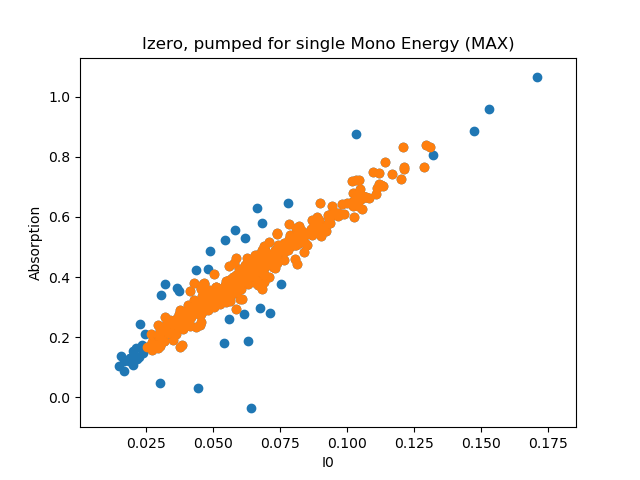

(11270,)


In [4]:
numstds = 3
minIzero = 0.025
lin_filter = 0.1

json_file = DIR_json + scan_name + "_scan_info.json"
print (json_file)

with open(json_file) as file:
    data = json.load(file)
numFiles = len(data['scan_files'])

print ("Processing",numFiles,"files")

DataFluo_pump_norm_total = np.empty(0)
DataFluo_unpump_norm_total = np.empty(0)
err_DataFluo_pump_total = np.empty(0)
err_DataFluo_unpump_total = np.empty(0)

IzeroFEL_pump_original_total = np.empty(0)
IzeroFEL_pump_total = np.empty(0)
IzeroFEL_unpump_original_total = np.empty(0)
IzeroFEL_unpump_total = np.empty(0)

DataFluo_pump_original_total = np.empty(0)
DataFluo_pump_total = np.empty(0)
DataFluo_unpump_original_total = np.empty(0)
DataFluo_unpump_total = np.empty(0)

noise_preFilter_pump = np.empty(numFiles)
noise_NoLinFilt_pump = np.empty(numFiles)
noise_withLin_pump = np.empty(numFiles)


noise_preFilter_short_pump = np.empty(numFiles)
noise_NoLinFilt_short_pump = np.empty(numFiles)
noise_withLin_short_pump = np.empty(numFiles)

noise_preFilter_unpump = np.empty(numFiles)
noise_NoLinFilt_unpump = np.empty(numFiles)
noise_withLin_unpump = np.empty(numFiles)

DataFluo_pump_pre = np.empty(numFiles)
IzeroFEL_pump_pre = np.empty(numFiles)

DataFluo_unpump_pre = np.empty(numFiles)
IzeroFEL_unpump_pre = np.empty(numFiles)


DataFluo_pump_mid = np.empty(numFiles)
IzeroFEL_pump_mid = np.empty(numFiles)

DataFluo_unpump_mid = np.empty(numFiles)
IzeroFEL_unpump_mid = np.empty(numFiles)


Energy_eV = np.empty(0)
iZero = np.empty(0)

for i in range(0,numFiles):
#for i in range(0,1):
    filename = str(data['scan_files'][i][0])
    filename = DIR + os.path.basename(filename)
    exists = os.path.isfile(filename)
    if not exists:
        print("No such file")
    elif exists:# and i!=39: #Do we need this 39?
#         print("step",i+1,"of",numFiles,": Processing %s" %(str(data['scan_files'][i][0])))
        
        (DataFluo_pump, DataFluo_unpump, IzeroFEL_pump, IzeroFEL_unpump, Energy, _, _, _) = \
            load_PumpProbe_events(filename, channel_energy)

        IzeroFEL_pump_original = IzeroFEL_pump.copy()
        IzeroFEL_unpump_original = IzeroFEL_unpump.copy()
        
        IzeroFEL_pump_original_total = np.append(IzeroFEL_pump_original_total, IzeroFEL_pump_original)
        IzeroFEL_unpump_original_total = np.append(IzeroFEL_unpump_original_total, IzeroFEL_unpump_original)
        
        DataFluo_pump_original_total = np.append(DataFluo_pump_original_total, DataFluo_pump)
        DataFluo_unpump_original_total = np.append(DataFluo_unpump_original_total, DataFluo_unpump)
        
        IzeroMedian = np.median(np.concatenate([IzeroFEL_pump, IzeroFEL_unpump]))
        IzeroSTD = np.std(np.concatenate([IzeroFEL_pump, IzeroFEL_unpump]))
        
        #calculate noise before filtering        
        noise_preFilter_pump[i] = np.std(DataFluo_pump)
        noise_preFilter_unpump[i] = np.std(DataFluo_unpump)
        
        
        n_short = round(len(DataFluo_pump.T[0])/4)
        
        noise_preFilter_short_pump[i] = np.std(DataFluo_pump[0:n_short])
        
#         print(noise_preFilter_short_pump)

#         print('thanng you want to looks at')
#         print(DataFluo_pump.shape)
#         print(DataFluo_pump.T[0].shape)
        

        
#         print(n_short)


#         noise_preFilter_pump = np.append(np.std(DataFluo_pump))

        
        #store temp vars to plot data pre filter at peak
        if i == 25:
            DataFluo_pump_temp = DataFluo_pump
            IzeroFEL_pump_temp = IzeroFEL_pump
            
            
        
        aa = DataFluo_pump.T[0]/IzeroFEL_pump.T[0]
        DataFluo_pump_pre[i] = aa.mean()
        
        aa = IzeroFEL_pump.T[0]
        IzeroFEL_pump_pre[i] = aa.mean()

        aa = DataFluo_unpump.T[0]/IzeroFEL_unpump.T[0]
        DataFluo_unpump_pre[i] = aa.mean()
        
        aa = IzeroFEL_unpump.T[0]
        IzeroFEL_unpump_pre[i] = aa.mean()
        
        #Izero filters
#         IzeroMedian+numstds*IzeroSTD
        
        conditionPumpMax = IzeroFEL_pump < IzeroMedian+numstds*IzeroSTD
        conditionPumpMin = IzeroFEL_pump > IzeroMedian-numstds*IzeroSTD
        conditionPumpLow = IzeroFEL_pump > minIzero

        conditionUnPumpMax = IzeroFEL_unpump < IzeroMedian+numstds*IzeroSTD
        conditionUnPumpMin = IzeroFEL_unpump > IzeroMedian-numstds*IzeroSTD
        conditionUnPumpLow = IzeroFEL_unpump > minIzero

        condIzeroPump = conditionPumpMax & conditionPumpMin & conditionPumpLow
        condIzeroUnPump = conditionUnPumpMax & conditionUnPumpMin & conditionUnPumpLow
        
        #update Fluo and Izero    

        IzeroFEL_pump = IzeroFEL_pump[condIzeroPump]
        IzeroFEL_unpump = IzeroFEL_unpump[condIzeroUnPump]
    
        DataFluo_pump = DataFluo_pump[condIzeroPump]
        DataFluo_unpump = DataFluo_unpump[condIzeroUnPump]
        
        
#         DataFluo_pump_mid[i] = DataFluo_pump
#         IzeroFEL_pump_mid[i] = IzeroFEL_pump

#         DataFluo_unpump_mid[i] = DataFluo_unpump
#         IzeroFEL_unpump_mid[i] = IzeroFEL_unpump
        
        
        
        aa = DataFluo_pump/IzeroFEL_pump
        DataFluo_pump_mid[i] = aa.mean()
        
        aa = IzeroFEL_pump
        IzeroFEL_pump_mid[i] = aa.mean()

        aa = DataFluo_unpump/IzeroFEL_unpump
        DataFluo_unpump_mid[i] = aa.mean()
        
        aa = IzeroFEL_unpump
        IzeroFEL_unpump_mid[i] = aa.mean()
        
        
        
        #calculate noise before the linear filter
        noise_NoLinFilt_pump[i] = np.std(DataFluo_pump)
        noise_NoLinFilt_unpump[i] = np.std(DataFluo_unpump)
        
        noise_NoLinFilt_short_pump[i] = np.std(DataFluo_pump[0:n_short])
        
        
        #apply filter to points which are not linear
        linFit_pump = np.polyfit(IzeroFEL_pump,DataFluo_pump,1)
        linFit_unpump = np.polyfit(IzeroFEL_unpump,DataFluo_unpump,1)
        
#         linFit_pump = np.polyfit(IzeroFEL_pump.T[0],DataFluo_pump.T[0],1)
#         linFit_unpump = np.polyfit(IzeroFEL_unpump.T[0],DataFluo_unpump.T[0],1)
        
        conditionPumpLinHigh =  DataFluo_pump < IzeroFEL_pump*linFit_pump[0]+linFit_pump[1]+lin_filter
        conditionPumpLinLow =  DataFluo_pump > IzeroFEL_pump*linFit_pump[0]+linFit_pump[1]-lin_filter
        
        conditionUnPumpLinHigh =  DataFluo_unpump < IzeroFEL_unpump*linFit_unpump[0]+linFit_unpump[1]+lin_filter
        conditionUnPumpLinLow =  DataFluo_unpump > IzeroFEL_unpump*linFit_unpump[0]+linFit_unpump[1]-lin_filter
        
        condLin_pump =  conditionPumpLinHigh & conditionPumpLinLow
        condLin_unpump = conditionUnPumpLinHigh & conditionUnPumpLinLow
        
        #update Fluo and Izero
        IzeroFEL_pump = IzeroFEL_pump[condLin_pump]
        IzeroFEL_unpump = IzeroFEL_unpump[condLin_unpump]
    
        DataFluo_pump = DataFluo_pump[condLin_pump]
        DataFluo_unpump = DataFluo_unpump[condLin_unpump]
        
        #calculate noise after the linear filter
        noise_withLin_pump[i] = np.std(DataFluo_pump)
        noise_withLin_unpump[i] = np.std(DataFluo_unpump)
        
        noise_withLin_short_pump[i] = np.std(DataFluo_pump[0:n_short])
        
        
        if i == 25:   # feel free to elmnate this if statement and following line
            
            plt.figure()
            plt.scatter(IzeroFEL_pump_temp, DataFluo_pump_temp)
            plt.scatter(IzeroFEL_pump, DataFluo_pump)
#             plt.scatter(IzeroFEL_pump_temp, DataFluo_pump_temp,marker='x')
            plt.title('Izero, pumped for single Mono Energy (MAX)')
            plt.xlabel('I0')
            plt.ylabel('Absorption')
            print(DataFluo_pump_total.shape)
        
    

        
        #resume appending fitlered data
        IzeroFEL_pump_total = np.append(IzeroFEL_pump_total, IzeroFEL_pump)
        IzeroFEL_unpump_total = np.append(IzeroFEL_unpump_total, IzeroFEL_unpump)
        
        DataFluo_pump_total = np.append(DataFluo_pump_total, DataFluo_pump)
        DataFluo_unpump_total = np.append(DataFluo_unpump_total, DataFluo_unpump)
        
        DataFluo_pump_norm = DataFluo_pump/IzeroFEL_pump
        DataFluo_unpump_norm = DataFluo_unpump/IzeroFEL_unpump
        
        DataFluo_pump_norm_total = np.append(DataFluo_pump_norm_total, DataFluo_pump_norm.mean())
        DataFluo_unpump_norm_total = np.append(DataFluo_unpump_norm_total, DataFluo_unpump_norm.mean())
        err_DataFluo_pump_total = np.append(err_DataFluo_pump_total, DataFluo_pump_norm.std()/np.sqrt(DataFluo_pump_norm.size))
        err_DataFluo_unpump_total = np.append(err_DataFluo_unpump_total, DataFluo_unpump_norm.std()/np.sqrt(DataFluo_unpump_norm.size))
        
        Energy = [x for x in Energy if (np.abs(x) > 0)]
        Energy_eV = np.append(Energy_eV, np.mean(Energy))
        iZero = np.append(iZero, np.mean(IzeroFEL_pump_total))
        

<IPython.core.display.Javascript object>


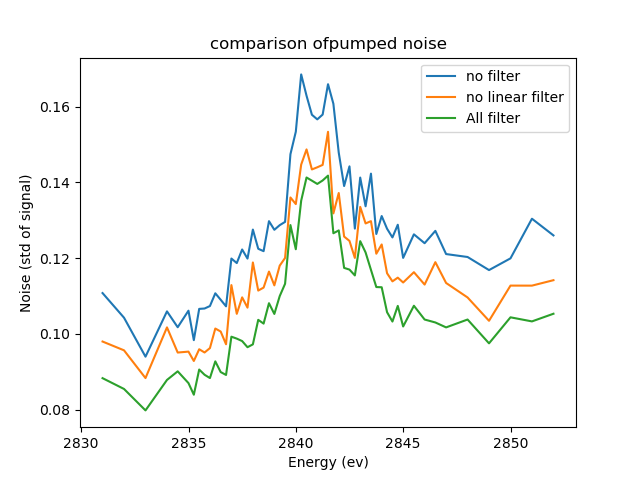

In [5]:
plt.figure()
plt.plot(Energy_eV,noise_preFilter_pump,label = 'no filter')
plt.plot(Energy_eV,noise_NoLinFilt_pump,label = 'no linear filter')
plt.plot(Energy_eV,noise_withLin_pump,label = 'All filter')
# plt.plot(np.array(Energy_eV), DataFluo_pump_norm_total/6*.1,label='Pumped')
plt.title('comparison ofpumped noise')
plt.xlabel('Energy (ev)')
plt.ylabel('Noise (std of signal)')
plt.legend()


<IPython.core.display.Javascript object>


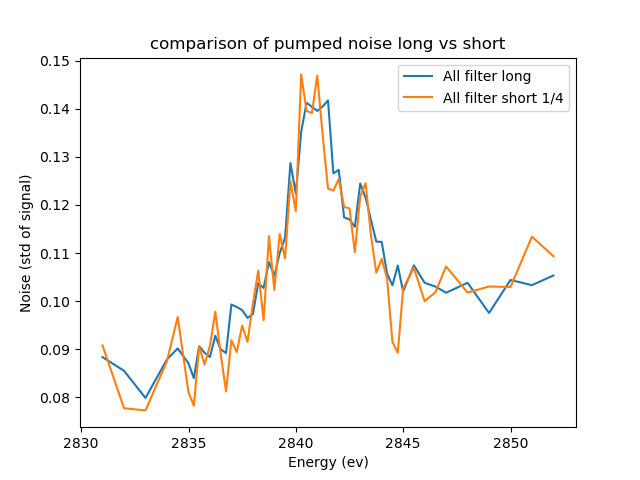

<IPython.core.display.Javascript object>


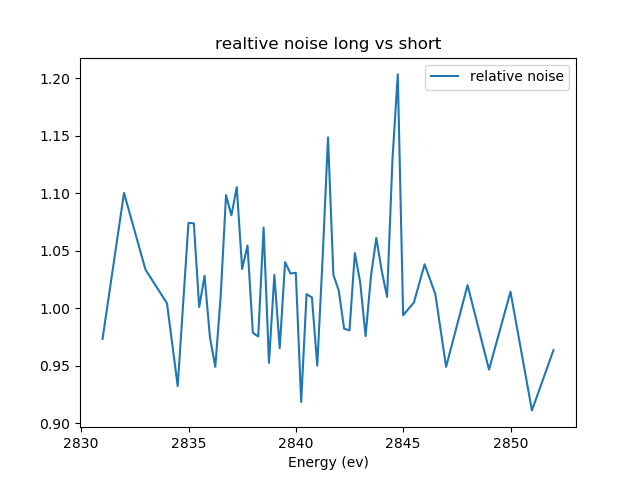

Text(0.5, 1.0, 'realtive noise long vs short')

In [15]:
# plt.figure()
# plt.plot(Energy_eV,noise_preFilter_pump/DataFluo_pump_pre,label = 'no filter long')
# plt.plot(Energy_eV,noise_preFilter_short_pump/DataFluo_pump_pre, label = 'no filter short 1/4')
# plt.title('comparison of pumped noise long vs short')
# plt.xlabel('Energy (ev)')
# plt.ylabel('Noise (std of signal)')
# plt.legend()

# plt.figure()
# plt.plot(Energy_eV,noise_NoLinFilt_pump/DataFluo_pump_mid,label = 'no linear filter long')
# plt.plot(Energy_eV,noise_NoLinFilt_short_pump/DataFluo_pump_mid,label = 'no linear filter short 1/4')
# plt.title('comparison of pumped noise long vs short')
# plt.xlabel('Energy (ev)')
# plt.ylabel('Noise (std of signal)')
# plt.legend()

plt.figure()
plt.plot(Energy_eV,noise_withLin_pump,label = 'All filter long')
plt.plot(Energy_eV,noise_withLin_short_pump, label = 'All filter short 1/4')
plt.title('comparison of pumped noise long vs short')
plt.xlabel('Energy (ev)')
plt.ylabel('Noise (std of signal)')
plt.legend()

plt.figure()
realtive_noise = noise_withLin_pump/noise_withLin_short_pump
plt.plot(Energy_eV,realtive_noise, label = 'relative noise')
plt.legend()
plt.xlabel('Energy (ev)')
plt.title('realtive noise long vs short')



# plt.plot(Energy_eV,DataFluo_pump_pre,label = 'no filter')
# plt.plot(Energy_eV,DataFluo_pump_mid,label = 'no linear filter')
# plt.plot(Energy_eV,DataFluo_pump_norm_total,label = 'All filter')


<IPython.core.display.Javascript object>


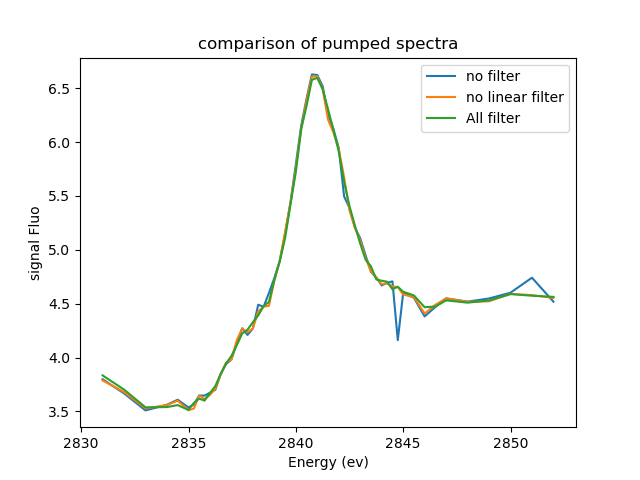

In [7]:
plt.figure()
plt.plot(Energy_eV,DataFluo_pump_pre,label = 'no filter')
plt.plot(Energy_eV,DataFluo_pump_mid,label = 'no linear filter')
plt.plot(Energy_eV,DataFluo_pump_norm_total,label = 'All filter')
# plt.plot(np.array(Energy_eV), DataFluo_unpump_norm_total/6*.1,label='unPumped')
plt.title('comparison of pumped spectra')
plt.xlabel('Energy (ev)')
plt.ylabel('signal Fluo')
plt.legend()

<IPython.core.display.Javascript object>


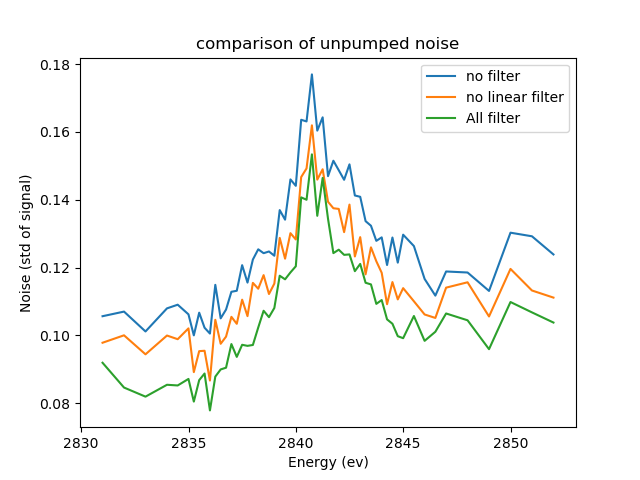

In [8]:
plt.figure()
plt.plot(Energy_eV,noise_preFilter_unpump,label = 'no filter')
plt.plot(Energy_eV,noise_NoLinFilt_unpump,label = 'no linear filter')
plt.plot(Energy_eV,noise_withLin_unpump,label = 'All filter')
# plt.plot(np.array(Energy_eV), DataFluo_unpump_norm_total/6*.1,label='unPumped')
plt.title('comparison of unpumped noise')
plt.xlabel('Energy (ev)')
plt.ylabel('Noise (std of signal)')
plt.legend()

<IPython.core.display.Javascript object>


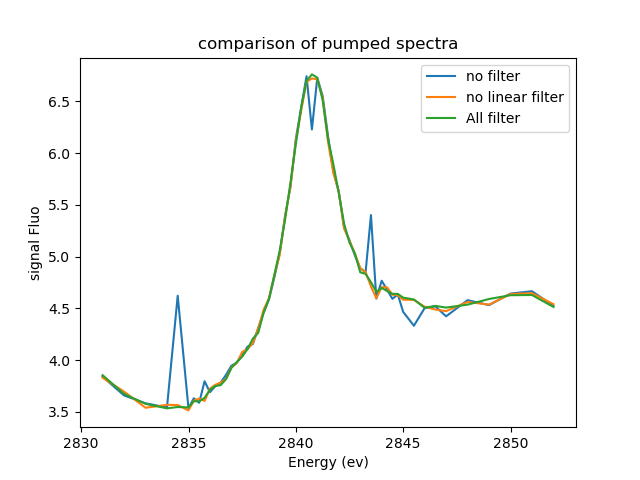

In [9]:
plt.figure()
plt.plot(Energy_eV,DataFluo_unpump_pre,label = 'no filter')
plt.plot(Energy_eV,DataFluo_unpump_mid,label = 'no linear filter')
plt.plot(Energy_eV,DataFluo_unpump_norm_total,label = 'All filter')
# plt.plot(np.array(Energy_eV), DataFluo_unpump_norm_total/6*.1,label='unPumped')
plt.title('comparison of pumped spectra')
plt.xlabel('Energy (ev)')
plt.ylabel('signal Fluo')
plt.legend()

Plot some diagnostics

The original number of pumped and unpumped shots is:
(27500,) (27500,)
The filtered number of pumped and unpumped shots is:
(24788,) (24720,)


<IPython.core.display.Javascript object>


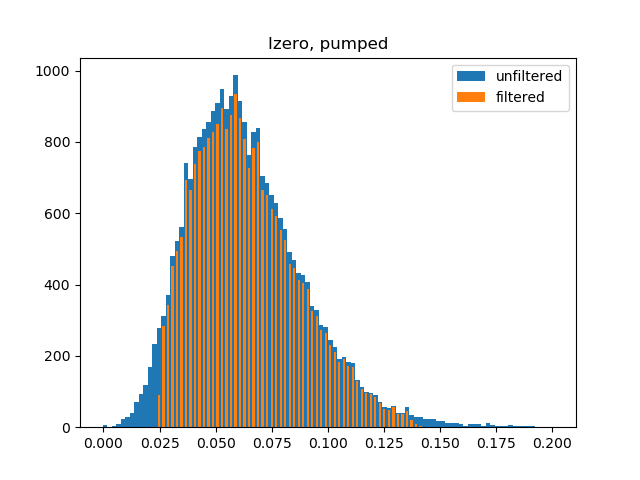

<IPython.core.display.Javascript object>


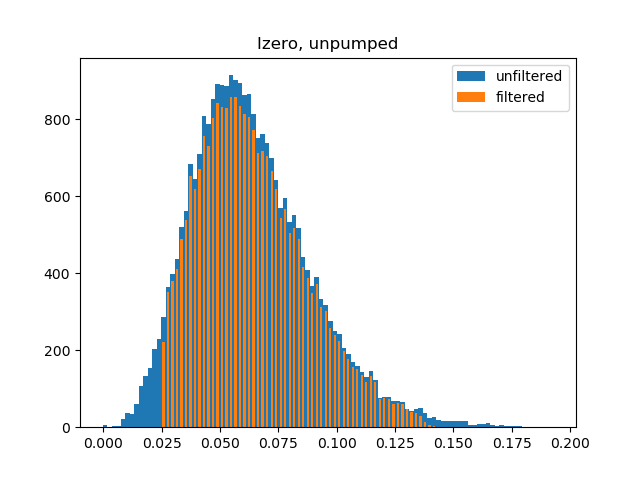

In [10]:
print("The original number of pumped and unpumped shots is:")
print(IzeroFEL_pump_original_total.shape, IzeroFEL_unpump_original_total.shape)
print("The filtered number of pumped and unpumped shots is:")
print(IzeroFEL_pump_total.shape, IzeroFEL_unpump_total.shape)

plt.figure()
_, bins, _ = plt.hist(IzeroFEL_pump_original_total, 100, label = 'unfiltered')
_ = plt.hist(IzeroFEL_pump_total, bins, rwidth = .5, label = 'filtered')
plt.title('Izero, pumped')
plt.legend()

plt.figure()
_, bins, _ = plt.hist(IzeroFEL_unpump_original_total, 100, label = 'unfiltered')
_ = plt.hist(IzeroFEL_unpump_total, bins, rwidth = .5, label = 'filtered')
plt.title('Izero, unpumped')
plt.legend()

<IPython.core.display.Javascript object>


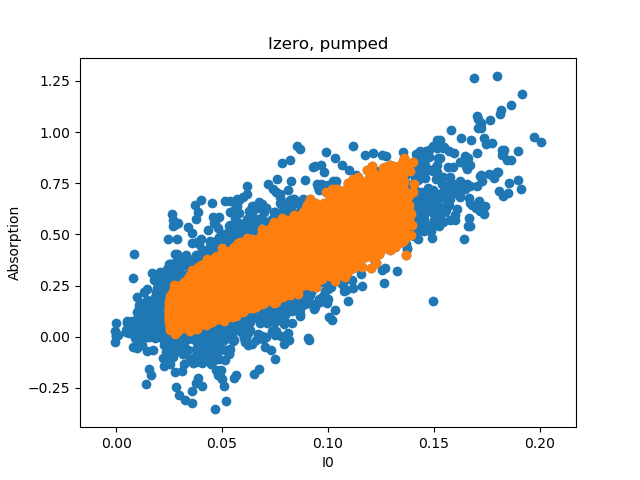

(24788,)


In [11]:
plt.figure()
plt.scatter(IzeroFEL_pump_original_total, DataFluo_pump_original_total)
plt.scatter(IzeroFEL_pump_total, DataFluo_pump_total)
plt.title('Izero, pumped')
plt.xlabel('I0')
plt.ylabel('Absorption')
print(DataFluo_pump_total.shape)

<IPython.core.display.Javascript object>


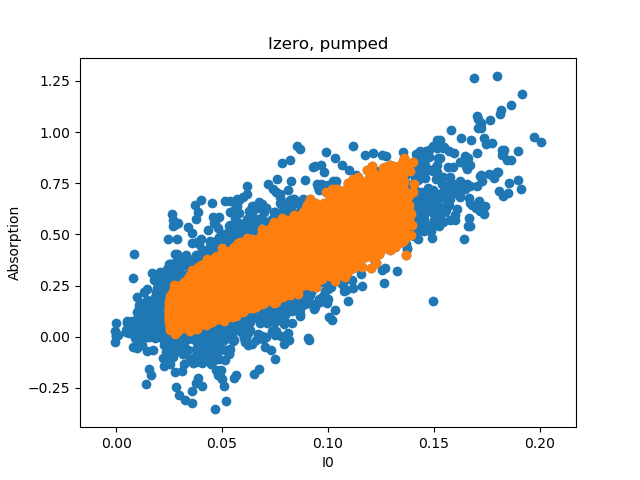

(24788,)


In [12]:
plt.figure()
plt.scatter(IzeroFEL_pump_original_total, DataFluo_pump_original_total)
plt.scatter(IzeroFEL_pump_total, DataFluo_pump_total)
plt.title('Izero, pumped')
plt.xlabel('I0')
plt.ylabel('Absorption')
print(DataFluo_pump_total.shape)

<IPython.core.display.Javascript object>


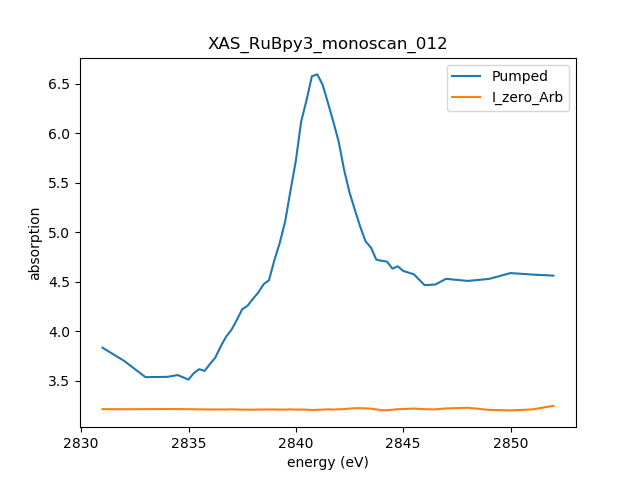

(55,)


In [13]:
plt.figure()
plt.plot(np.array(Energy_eV), DataFluo_pump_norm_total,label='Pumped')
# plt.plot(np.array(Energy_eV), DataFluo_unpump_norm_total,label='UnPumped')
plt.plot(np.array(Energy_eV), np.array(iZero)*50,label="I_zero_Arb")
plt.xlabel('energy (eV)')
plt.ylabel('absorption')
plt.title('XAS_'+ scan_name)
plt.legend()

print(DataFluo_pump_norm_total.shape)